In [828]:
import numpy as np
import pandas as pd
import seaborn as sns
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from test_and_graphing import community_detection, community_strength
from sklearn.cluster import KMeans
from IPython.display import display

In [829]:
def draw_graph(A:np.ndarray, group_labels=None):
    n = A.shape[0]
    G = nx.from_numpy_array(A, create_using=nx.Graph)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=True, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color="black")

# graph structure

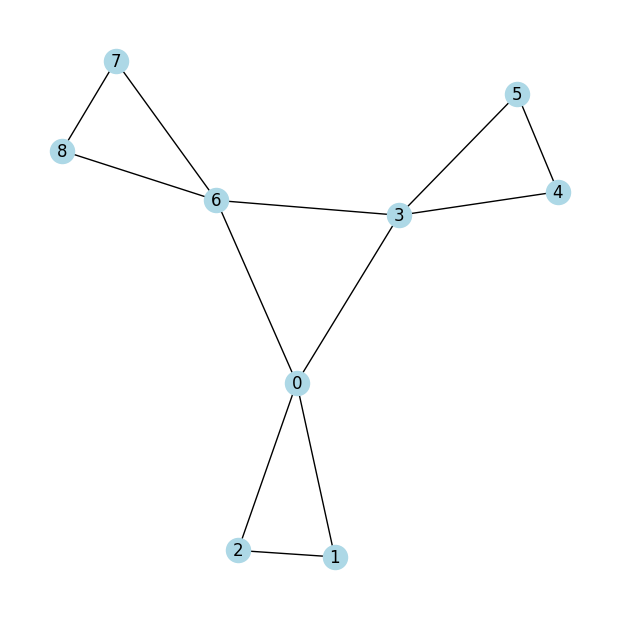

In [830]:
# AL = {
#     0: [1,3],
#     1: [0,2],
#     2: [1,3],
#     3: [0,2,4,6],
#     4: [3,5],
#     5: [4,6],
#     6: [3,5],
# }

AL = {
    0: [1,2,3,6],
    1: [0,2],
    2: [0,1],
    3: [4,5,0,6],
    4: [3,5],
    5: [3,4],
    6: [7,8,0,3],
    7: [6,8],
    8: [6,7]
}

# AL = {
#     0: [1,2,3],
#     1: [0,2,3],
#     2: [0,1,3],
#     3: [0,2,4,1],
#     4: [5,7,6,3],
#     5: [4,6,7],
#     6: [5,7,4],
#     7: [4,5,6],
# }

# AL = {
#     0: [1,5],
#     1: [0,2],
#     2: [1,3],
#     3: [2,4],
#     4: [3,5],
#     5: [4,0]
# }

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

# Doing an SVD decomposition on the |L|= D + A

In [831]:
L_ABS = D + A
U, S, Vt = np.linalg.svd(L_ABS)
V = Vt.T
S = np.diag(S)

<Axes: >

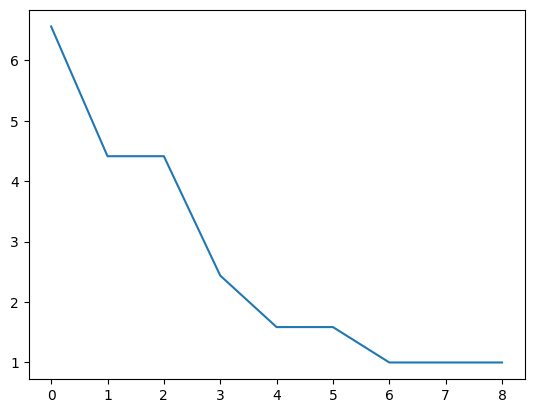

In [832]:
svs = np.diag(S)
sns.lineplot(svs)

In [833]:
k = 3 # rank (has to be more than 1)
U_k = U[:,0:k]
S_k = S[0:k,0:k]
V_k = V[:,0:k]

# Compute cosine matrix

In [834]:
CM = np.zeros((m,n))
vectors = S_k @ V_k.T
for i in range(0,vectors.shape[1]):
    for j in range(i+1, vectors.shape[1]):
        u = vectors[:,i]
        v = vectors[:,j]
        cosine = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
        CM[i,j] = cosine
        CM[j,i] = cosine
np.fill_diagonal(CM, 1)

print(CM)

[[ 1.          0.9036824   0.9036824   0.4842931   0.13256715  0.13256715
   0.4842931   0.13256715  0.13256715]
 [ 0.9036824   1.          1.          0.13256715 -0.15301686 -0.15301686
   0.13256715 -0.15301686 -0.15301686]
 [ 0.9036824   1.          1.          0.13256715 -0.15301686 -0.15301686
   0.13256715 -0.15301686 -0.15301686]
 [ 0.4842931   0.13256715  0.13256715  1.          0.9036824   0.9036824
   0.4842931   0.13256715  0.13256715]
 [ 0.13256715 -0.15301686 -0.15301686  0.9036824   1.          1.
   0.13256715 -0.15301686 -0.15301686]
 [ 0.13256715 -0.15301686 -0.15301686  0.9036824   1.          1.
   0.13256715 -0.15301686 -0.15301686]
 [ 0.4842931   0.13256715  0.13256715  0.4842931   0.13256715  0.13256715
   1.          0.9036824   0.9036824 ]
 [ 0.13256715 -0.15301686 -0.15301686  0.13256715 -0.15301686 -0.15301686
   0.9036824   1.          1.        ]
 [ 0.13256715 -0.15301686 -0.15301686  0.13256715 -0.15301686 -0.15301686
   0.9036824   1.          1.        ]]

# Reorder cosine matrix

In [835]:
INDEX = [] # global reordering index
CM_COPY = CM.copy()
indices = list(range(0,CM.shape[1]))
while(len(indices) > 1):
    # sort by cosine similarity
    similarity_list = CM_COPY[0,:]
    new_indices = np.argsort(similarity_list)[::-1]
    
    # rearrange matrix
    indices = [indices[i] for i in new_indices]
    CM_COPY = CM_COPY[np.ix_(new_indices,new_indices)]

    # remove and update
    INDEX.append(indices[0])
    indices.pop(0)
    CM_COPY = CM_COPY[1:,1:]
INDEX.append(indices[0])
del CM_COPY
CM_REORDERED = CM[np.ix_(INDEX, INDEX)]

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

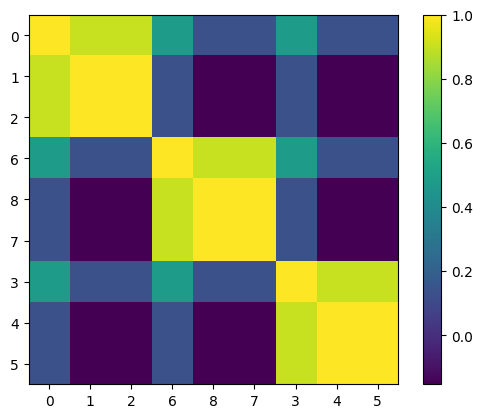

In [836]:
# print(INDEX)
# for r in range(CM_REORDERED.shape[0]):
#     line = ""
#     for c in range(CM_REORDERED.shape[1]):
#         line += str(CM_REORDERED[r,c])
#         if (c < CM_REORDERED.shape[1] - 1):
#             line += ","
#     print(line)

import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

# trying to algorithmically find the clusters

### summing square from the diagonal

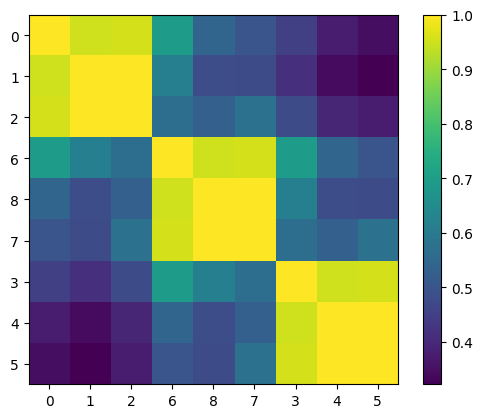

In [843]:
def sum_from_diag(mat:np.ndarray):
    n = mat.shape[0]
    assert mat.shape[0] == mat.shape[1]
    '''Returns a matrix where each (i,j) is the square-shaped sum of all cells of the input matrix between and including (i,j) and (j,i)'''
    sum_mat = np.zeros((n,n))
    for r in range(0,n):
        for c in range(r,n):
            lo_diag = min(r,c)
            hi_diag = max(r,c) + 1
            temp = np.sum(mat[lo_diag:hi_diag,lo_diag:hi_diag])
            sum_mat[r,c] = temp
            sum_mat[c,r] = temp
    return sum_mat

def mean_from_diag(mat:np.ndarray):
    n = mat.shape[0]
    assert mat.shape[0] == mat.shape[1]
    sum_mat = sum_from_diag(mat)
    squares_size = np.zeros((n,n))
    for r in range(0,n):
        for c in range(r,n):
            lo_diag = min(r,c)
            hi_diag = max(r,c) + 1
            diff = hi_diag - lo_diag
            squares_size[r,c] = diff ** 2
            squares_size[c,r] = diff ** 2
    return sum_mat / squares_size

CM_SUM = mean_from_diag(CM_REORDERED)

plt.imshow(CM_SUM, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

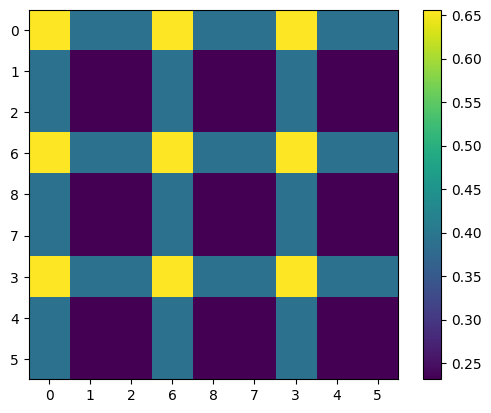

In [838]:
CMU, CMS, CMVt = np.linalg.svd(CM_REORDERED)
CMV = CMVt.T
CMS = np.diag(CMS)

s = 0 #using the 2nd singular value you can see the clusters a lot more distinctively

CMU_k = CMU[:,s:s+1]
CMS_k = CMS[s:s+1,s:s+1]
CMV_k = CMV[:,s:s+1]

disp_mat = CMU_k @ CMS_k @ CMV_k.T
plt.imshow(disp_mat, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

In [839]:
community_detection(CM_REORDERED, 0.5, sliced=False)

[(0, 3), (3, 6), (6, 9)]

In [840]:
community_strength(CM_REORDERED, 0.5)

[[ 0.00000000e+00 -9.63175955e-02 -9.63175955e-02]
 [-9.63175955e-02  0.00000000e+00 -2.22044605e-16]
 [-9.63175955e-02 -2.22044605e-16  0.00000000e+00]]
[[ 0.00000000e+00 -9.63175955e-02 -9.63175955e-02]
 [-9.63175955e-02  0.00000000e+00  2.22044605e-16]
 [-9.63175955e-02  2.22044605e-16  0.00000000e+00]]
[[ 0.00000000e+00 -9.63175955e-02 -9.63175955e-02]
 [-9.63175955e-02  0.00000000e+00  2.22044605e-16]
 [-9.63175955e-02  2.22044605e-16  0.00000000e+00]]


[0.864, 0.864, 0.864]